In [ ]:
!pip install streamlit

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from xgboost import XGBRegressor
import pickle
import os
import streamlit as st
from PIL import Image
import subprocess

Dataset Overview and Summary

In [ ]:
data = pd.read_csv("Concrete_Data.csv")

info = data.info()
description = data.describe()

sns.set_theme(style="whitegrid")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

Target Variable Distribution: Concrete Strength

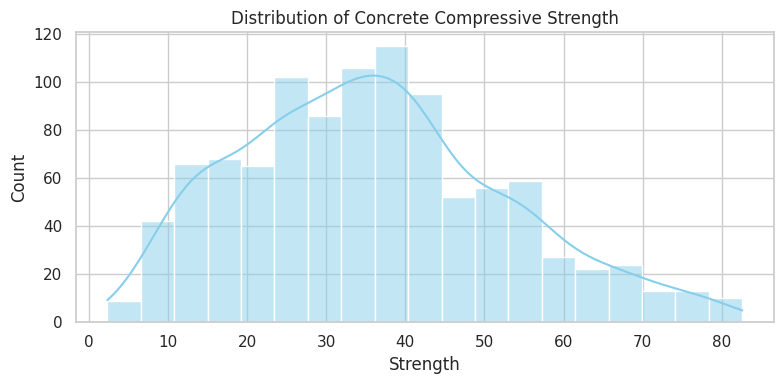

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(data['Concrete compressive strength(MPa, megapascals) '], kde=True, color='skyblue')
plt.title("Distribution of Concrete Compressive Strength")
plt.xlabel("Strength")
plt.tight_layout()
plt.savefig("preprocessing_data/target_distribution.png")

Feature-wise Distribution Overview

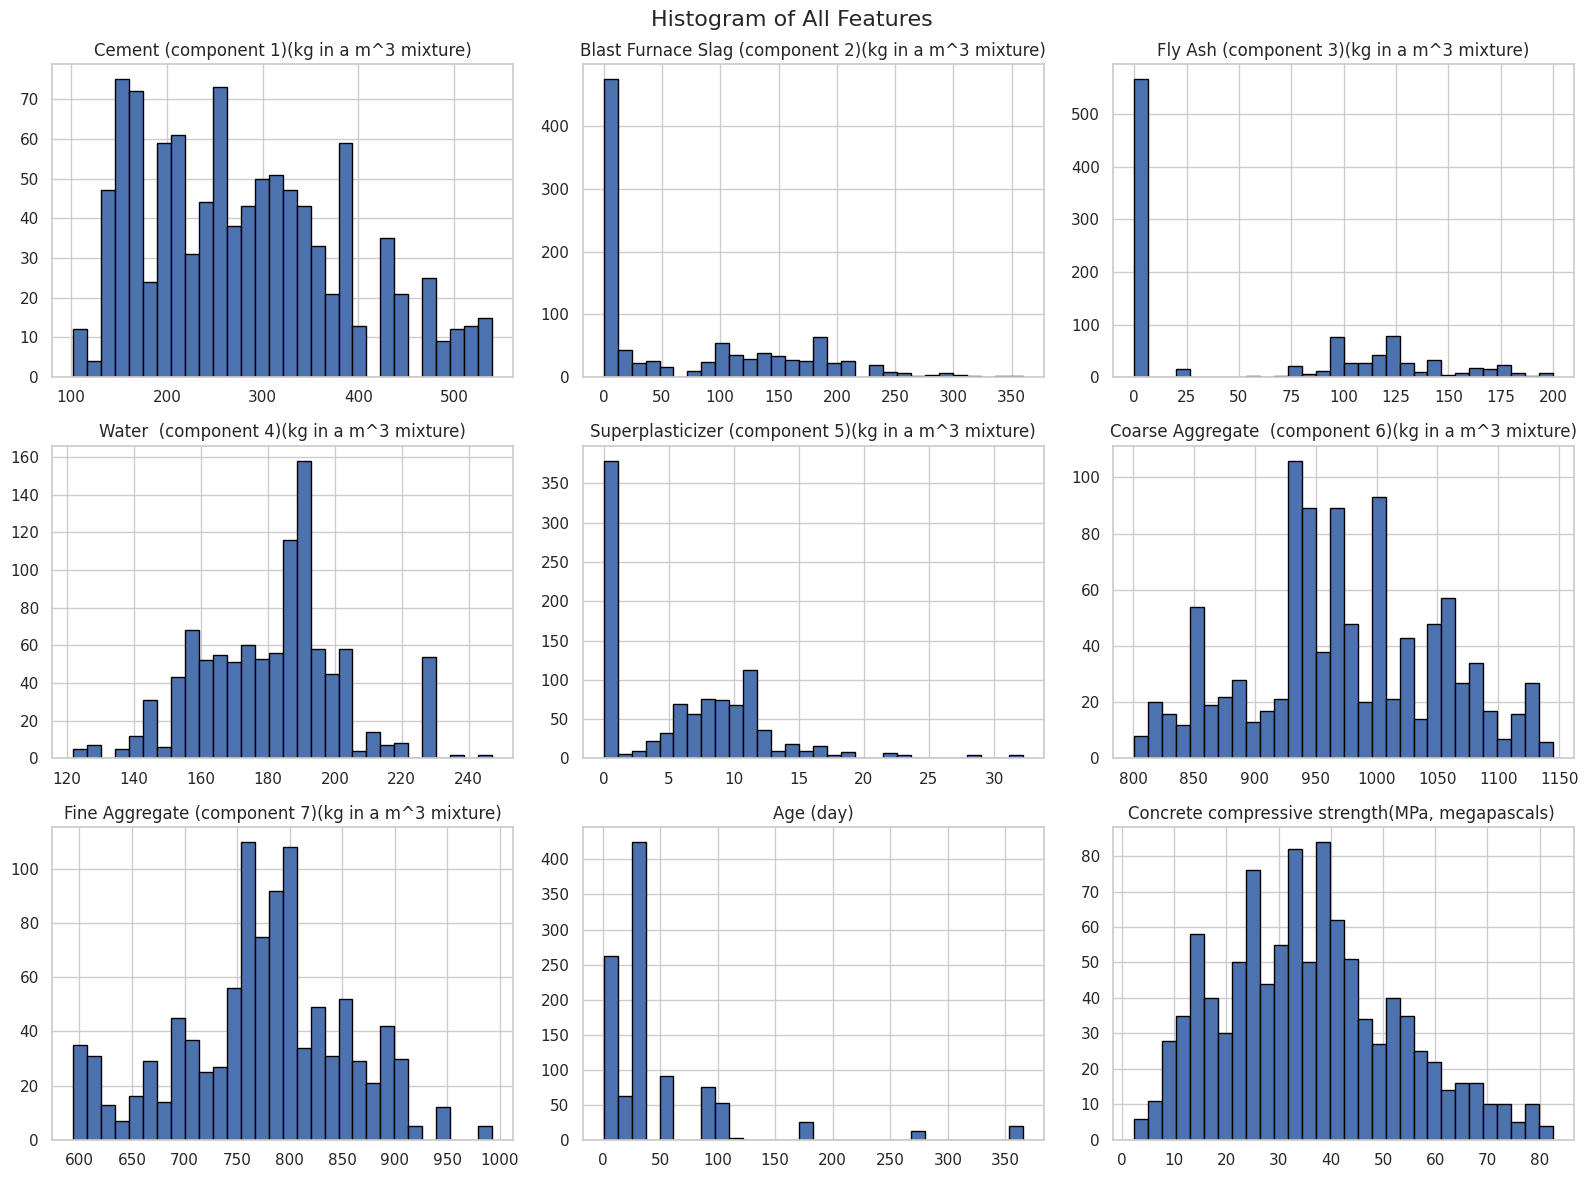

In [ ]:
data.hist(bins=30, figsize=(16, 12), edgecolor='black')
plt.suptitle("Histogram of All Features", fontsize=16)
plt.tight_layout()
plt.savefig("preprocessing_data/feature_histograms.png")

Feature Correlation Heatmap

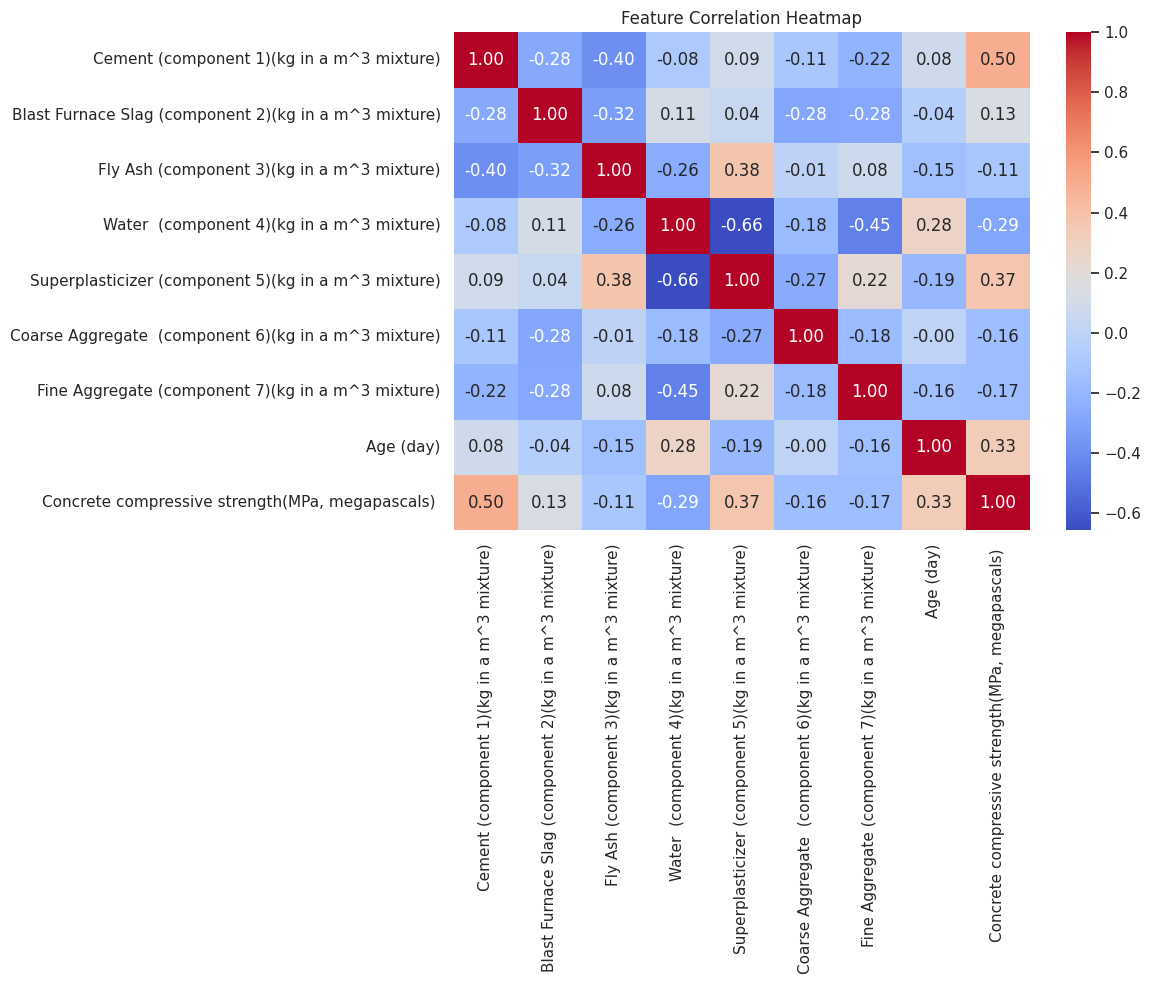

In [ ]:
plt.figure(figsize=(12, 10))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("preprocessing_data/correlation_heatmap.png")

Visualizing Feature Relationships with Concrete Strength - Feature vs Target scatter plots

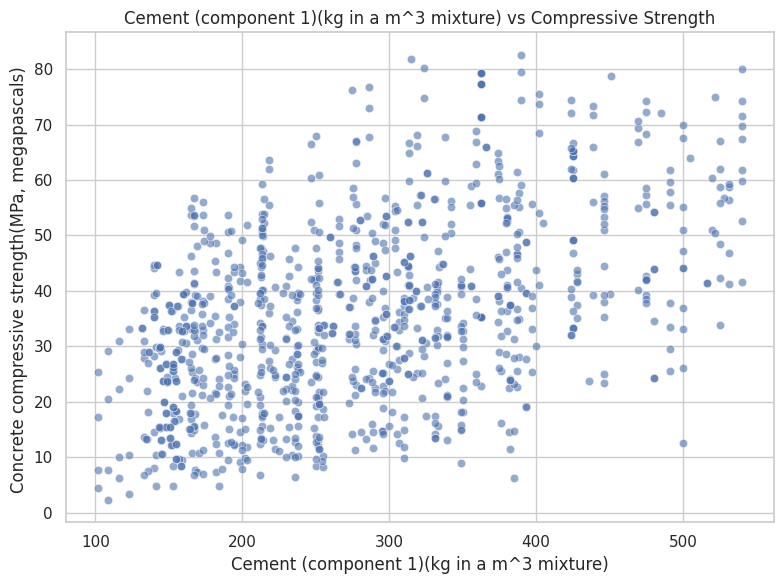

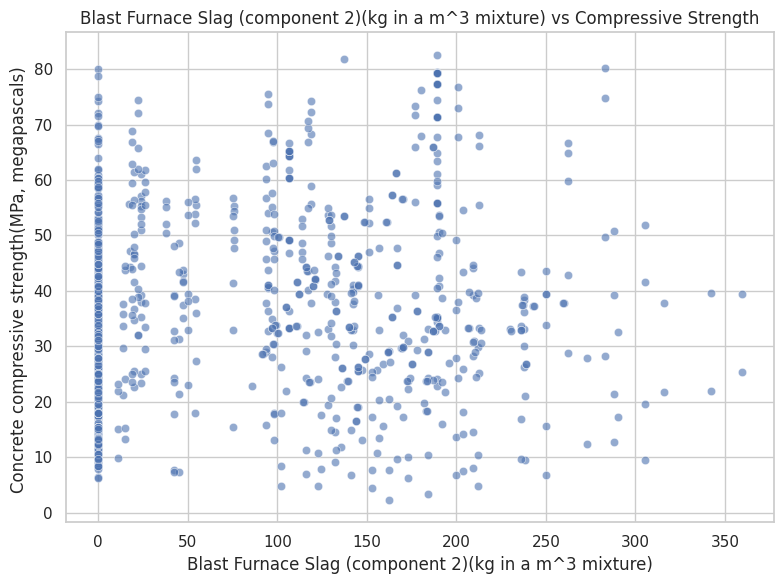

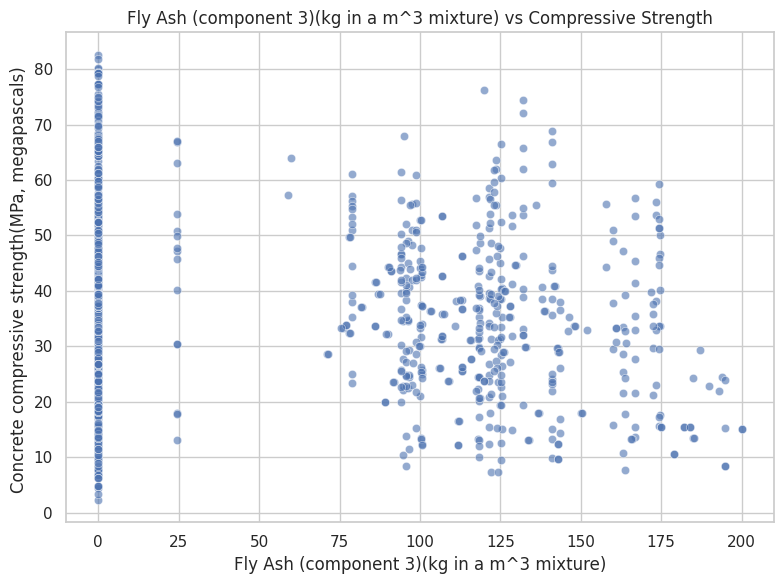

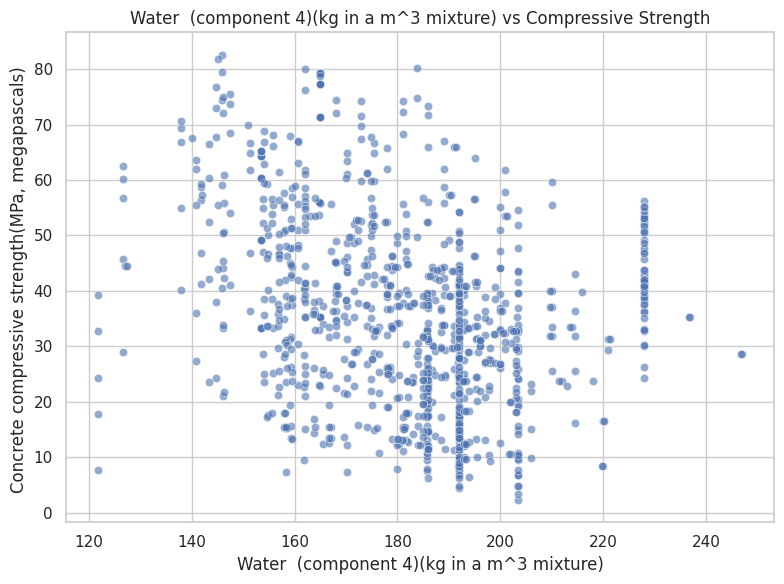

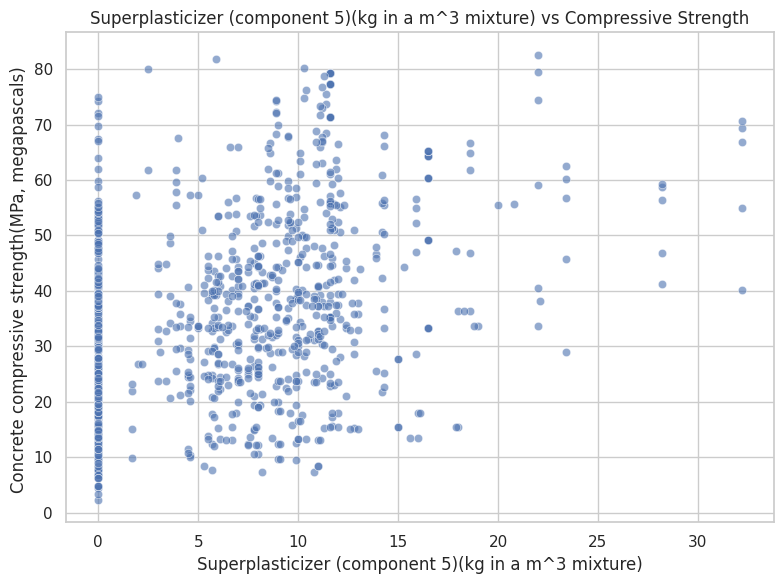

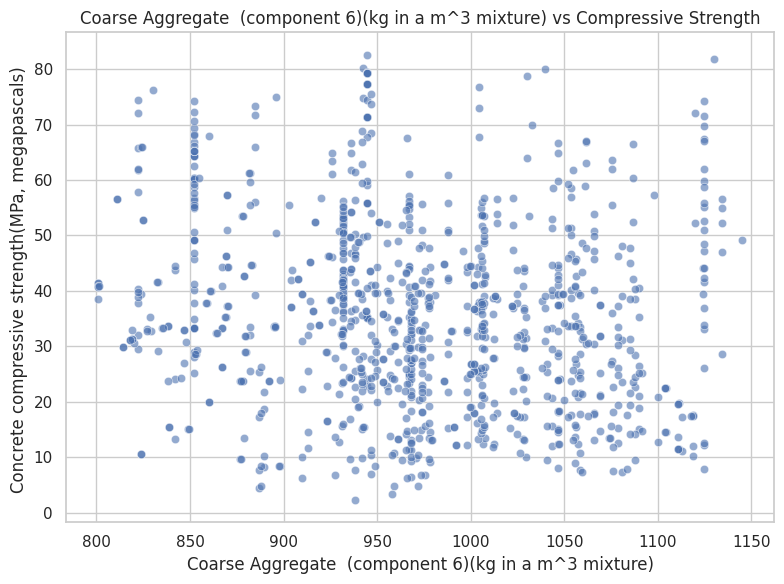

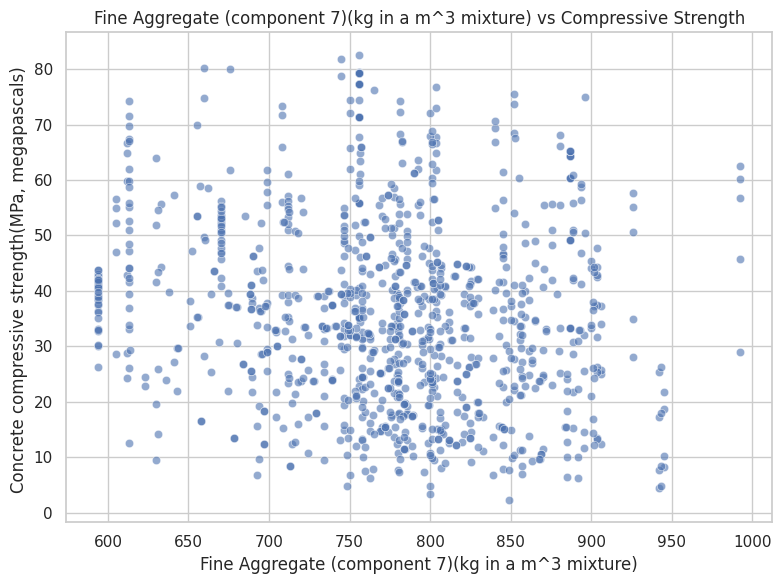

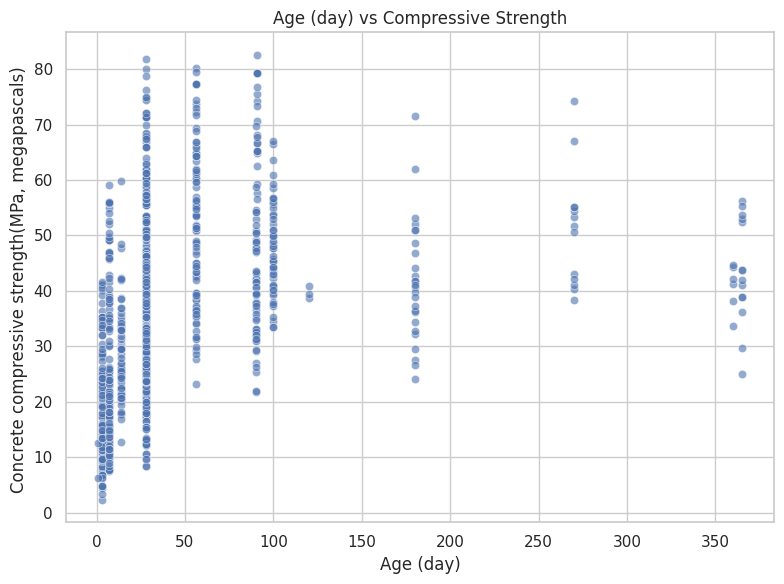

In [ ]:
for col in data.columns[:-1]:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[col], y=data['Concrete compressive strength(MPa, megapascals) '], alpha=0.6)
    plt.title(f"{col} vs Compressive Strength")
    plt.tight_layout()
    plt.savefig("preprocessing_data/{col}_vs_strength.png")

Boxplots for outlier detection

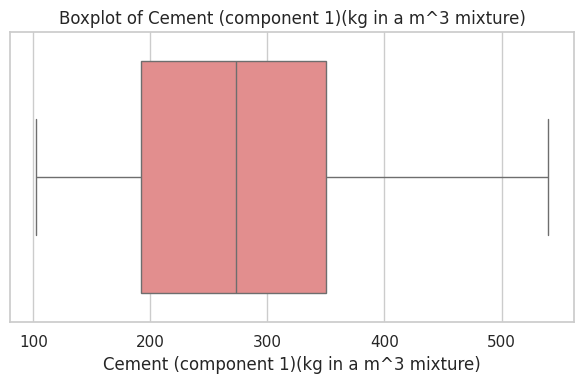

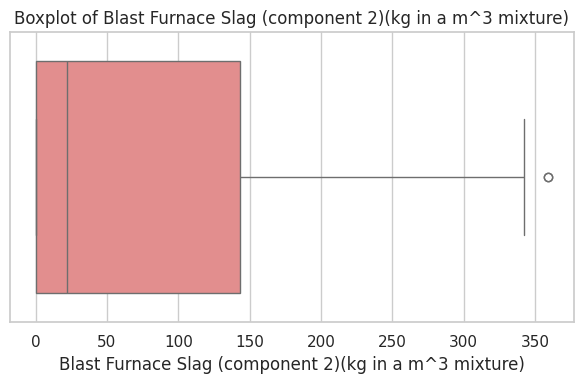

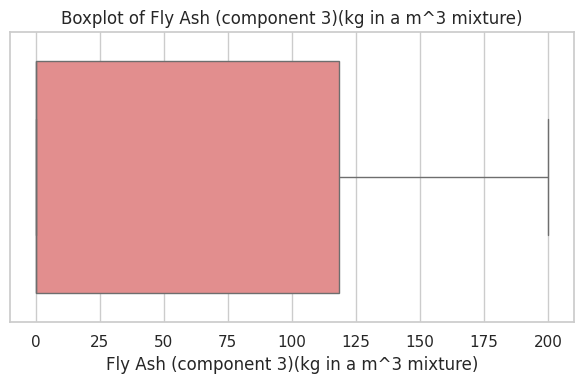

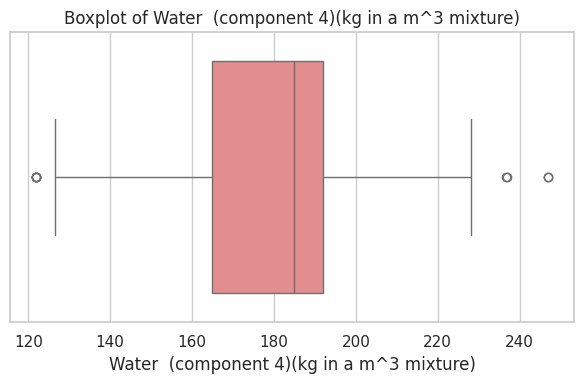

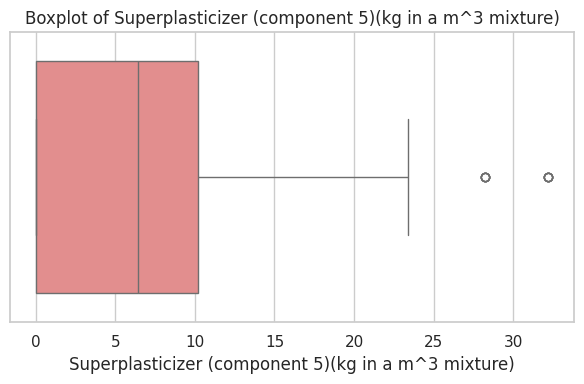

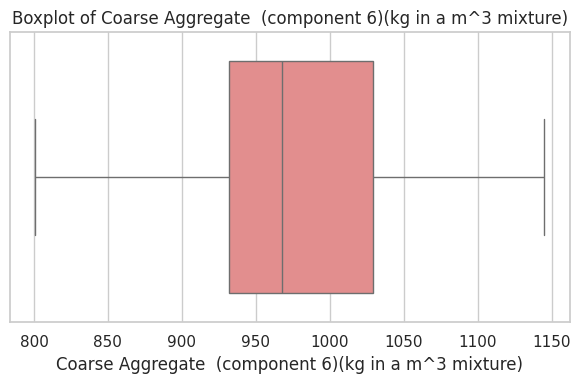

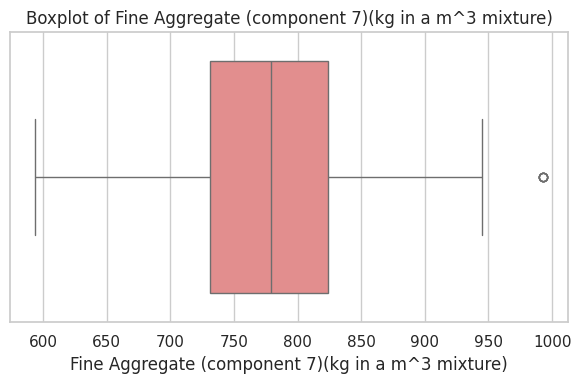

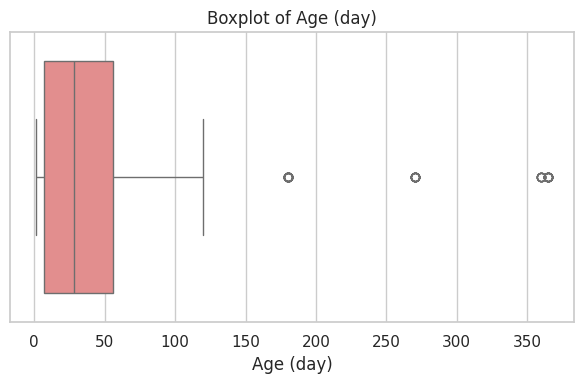

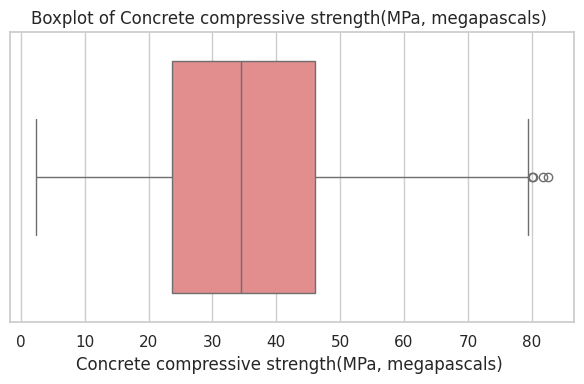

In [ ]:
for col in data.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col], color='lightcoral')
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()

Rename Columns for Clarity

In [ ]:
data.columns = ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer',
              'coarse_agg', 'fine_agg', 'age', 'strength']

Outlier Treatment for Age column

In [ ]:
# Calculate IQR for Age
Q1 = data['age'].quantile(0.25)
Q3 = data['age'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers
data['age'] = np.where(data['age'] > upper_bound, upper_bound,
                    np.where(data['age'] < lower_bound, lower_bound, data['age']))

Box Plot for Age feature after Outlier treatment

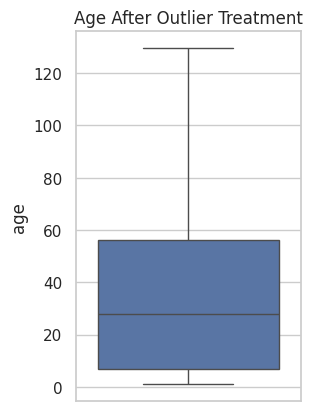

In [ ]:
plt.subplot(1, 2, 2)
sns.boxplot(y=data['age'])
plt.title('Age After Outlier Treatment')
plt.show()

Check Missing Values

In [ ]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 cement              0
slag                0
fly_ash             0
water               0
superplasticizer    0
coarse_agg          0
fine_agg            0
age                 0
strength            0
dtype: int64


Summary Statistics

In [ ]:
print("\nSummary Statistics:\n", data.describe())


Summary Statistics:
             cement         slag      fly_ash        water  superplasticizer  \
count  1030.000000  1030.000000  1030.000000  1030.000000       1030.000000   
mean    281.167864    73.895825    54.188350   181.567282          6.204660   
std     104.506364    86.279342    63.997004    21.354219          5.973841   
min     102.000000     0.000000     0.000000   121.800000          0.000000   
25%     192.375000     0.000000     0.000000   164.900000          0.000000   
50%     272.900000    22.000000     0.000000   185.000000          6.400000   
75%     350.000000   142.950000   118.300000   192.000000         10.200000   
max     540.000000   359.400000   200.100000   247.000000         32.200000   

        coarse_agg     fine_agg          age     strength  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918932   773.580485    38.070388    35.817961  
std      77.753954    80.175980    35.782271    16.705742  
min     801.000000   594.0

Correlation Heatmap

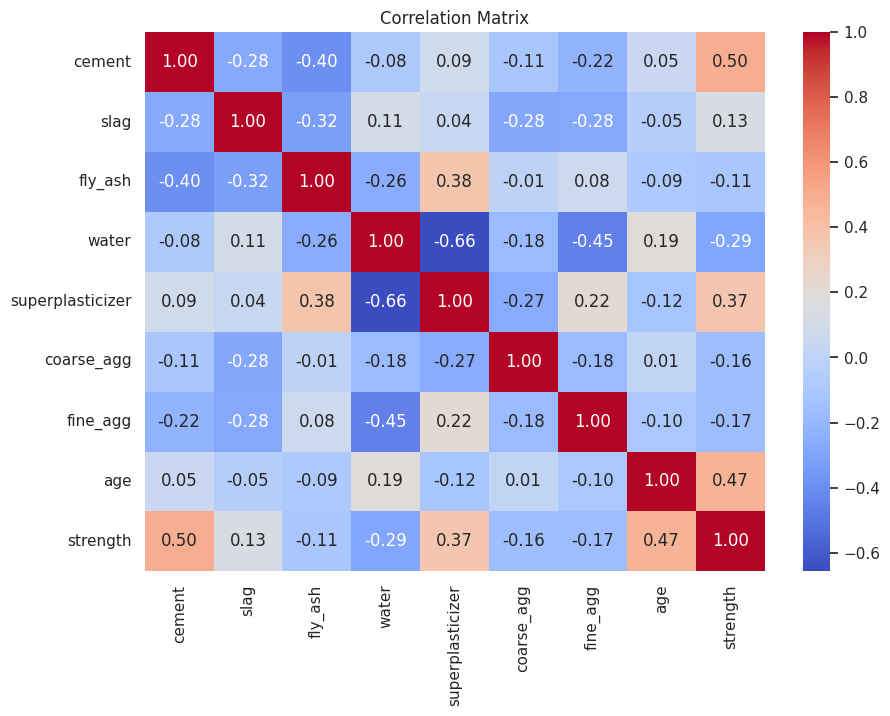

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Outlier Removal using Z-Score

In [ ]:
z_scores = np.abs(stats.zscore(data))
outlier_indices = np.where(z_scores > 3)
outlier_rows = np.unique(outlier_indices[0])
df = data.drop(index=outlier_rows).reset_index(drop=True)
print(f"\nRemoved {len(outlier_rows)} outliers.")


Removed 16 outliers.


Skewness Before Transformation

In [ ]:
# Skewness Before Transformation
skew_before = df.drop(columns='strength').skew()
print("\nSkewness Before Log Transform:\n", skew_before)


Skewness Before Log Transform:
 cement              0.496282
slag                0.751291
fly_ash             0.516119
water               0.061233
superplasticizer    0.462304
coarse_agg         -0.055569
fine_agg           -0.255447
age                 1.262057
dtype: float64


Log Transform for Skewed Features

In [ ]:
for col in df.columns[:-1]:
    if df[col].skew() > 0.5:
        df[col] = np.log1p(df[col])

Skewness After Transformation

In [ ]:
skew_after = df.drop(columns='strength').skew()
print("\nSkewness After Log Transform:\n", skew_after)


Skewness After Log Transform:
 cement              0.496282
slag               -0.023583
fly_ash             0.205880
water               0.061233
superplasticizer    0.462304
coarse_agg         -0.055569
fine_agg           -0.255447
age                -0.321492
dtype: float64


Feature Scaling,
Standard Scaler

In [ ]:
standard_scaler_X = StandardScaler()
standard_scaler_y = StandardScaler()

X_scaled_std = standard_scaler_X.fit_transform(data.drop(columns='strength'))
y_scaled_std = standard_scaler_y.fit_transform(data[['strength']])  # keep 2D

df_standard_scaled = pd.DataFrame(X_scaled_std, columns=data.columns[:-1])
df_standard_scaled['strength'] = y_scaled_std

Min-Max Scaler

In [ ]:
minmax_scaler_X = MinMaxScaler()
minmax_scaler_y = MinMaxScaler()

X_scaled = minmax_scaler_X.fit_transform(data.drop(columns='strength'))
y_scaled = minmax_scaler_y.fit_transform(data[['strength']])  # keep as 2D

df_minmax_scaled = pd.DataFrame(X_scaled, columns=data.columns[:-1])
df_minmax_scaled['strength'] = y_scaled  # still scaled target

os.makedirs('models', exist_ok=True)
with open("models/minmax_scaler_X.pkl", "wb") as f:
    pickle.dump(minmax_scaler_X, f)

with open("models/minmax_scaler_y.pkl", "wb") as f:
    pickle.dump(minmax_scaler_y, f)

Scaled Data

In [ ]:
print("\nStandard Scaled Sample:\n", df_standard_scaled.head())
print("\nMinMax Scaled Sample:\n", df_minmax_scaled.head())


Standard Scaled Sample:
      cement      slag   fly_ash     water  superplasticizer  coarse_agg  \
0  2.477915 -0.856888 -0.847144 -0.916764         -0.620448    0.863154   
1  2.477915 -0.856888 -0.847144 -0.916764         -0.620448    1.056164   
2  0.491425  0.795526 -0.847144  2.175461         -1.039143   -0.526517   
3  0.491425  0.795526 -0.847144  2.175461         -1.039143   -0.526517   
4 -0.790459  0.678408 -0.847144  0.488793         -1.039143    0.070527   

   fine_agg       age  strength  
0 -1.217670 -0.281572  2.645408  
1 -1.217670 -0.281572  1.561421  
2 -2.240917  2.556406  0.266627  
3 -2.240917  2.556406  0.313340  
4  0.647884  2.556406  0.507979  

MinMax Scaled Sample:
      cement      slag  fly_ash     water  superplasticizer  coarse_agg  \
0  1.000000  0.000000      0.0  0.321086           0.07764    0.694767   
1  1.000000  0.000000      0.0  0.321086           0.07764    0.738372   
2  0.526256  0.396494      0.0  0.848243           0.00000    0.380814   

Save the MinMax scaled data to a CSV file

In [ ]:
df_minmax_scaled.to_csv("Concrete_MinMax_Scaled.csv", index=False)
print("File saved as Concrete_MinMax_Scaled.csv")

File saved as Concrete_MinMax_Scaled.csv


Show the first 5 rows of the MinMax Scaled DataFrame

In [ ]:
print(df_minmax_scaled.head())

     cement      slag  fly_ash     water  superplasticizer  coarse_agg  \
0  1.000000  0.000000      0.0  0.321086           0.07764    0.694767   
1  1.000000  0.000000      0.0  0.321086           0.07764    0.738372   
2  0.526256  0.396494      0.0  0.848243           0.00000    0.380814   
3  0.526256  0.396494      0.0  0.848243           0.00000    0.380814   
4  0.220548  0.368392      0.0  0.560703           0.00000    0.515698   

   fine_agg       age  strength  
0  0.205720  0.210117  0.967485  
1  0.205720  0.210117  0.741996  
2  0.000000  1.000000  0.472655  
3  0.000000  1.000000  0.482372  
4  0.580783  1.000000  0.522860  


In [ ]:
# Load data
df = pd.read_csv('Concrete_MinMax_Scaled.csv')

# Display first few rows
df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,strength
0,1.000000,0.000000,0.0,0.321086,0.07764,0.694767,0.205720,0.210117,0.967485
1,1.000000,0.000000,0.0,0.321086,0.07764,0.738372,0.205720,0.210117,0.741996
2,0.526256,0.396494,0.0,0.848243,0.00000,0.380814,0.000000,1.000000,0.472655
3,0.526256,0.396494,0.0,0.848243,0.00000,0.380814,0.000000,1.000000,0.482372
4,0.220548,0.368392,0.0,0.560703,0.00000,0.515698,0.580783,1.000000,0.522860


Train, Test, Split

In [ ]:
# The last column is the target (Concrete compressive strength)
X = df.iloc[:, :-1]
y = df.iloc[:, -1].values.reshape(-1, 1)

# Split the dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Machine Learning Models

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'KNeighbors': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
}

In [ ]:
save_path = 'models/'
os.makedirs(save_path, exist_ok=True)

Model Evaluation

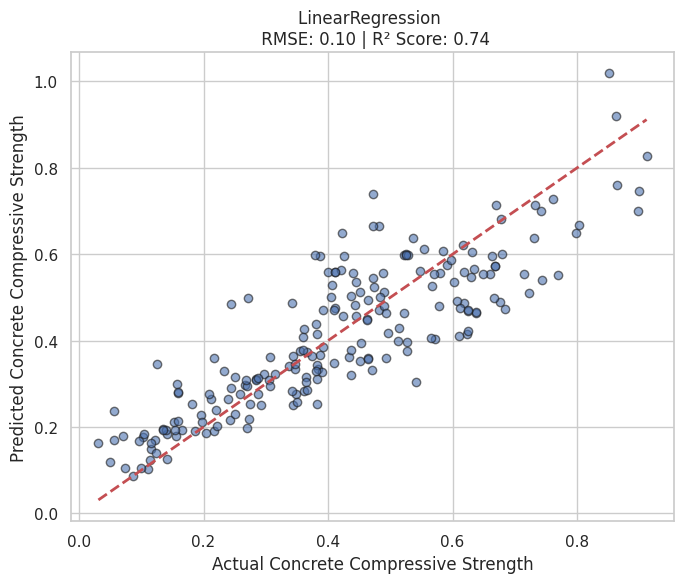

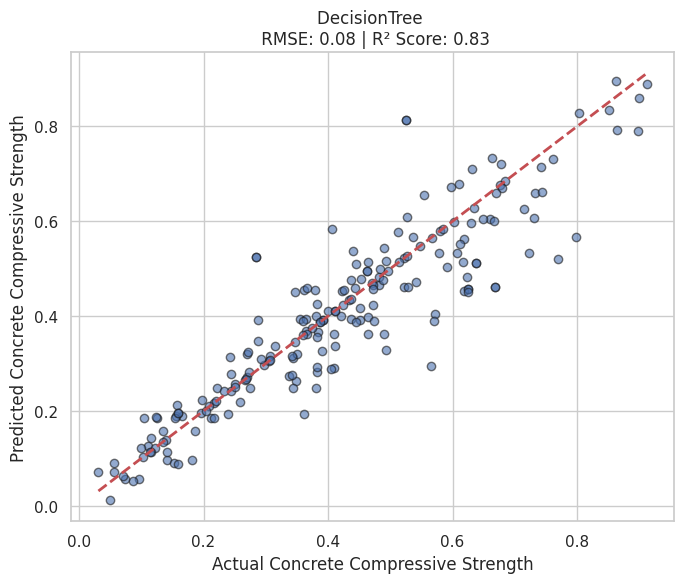

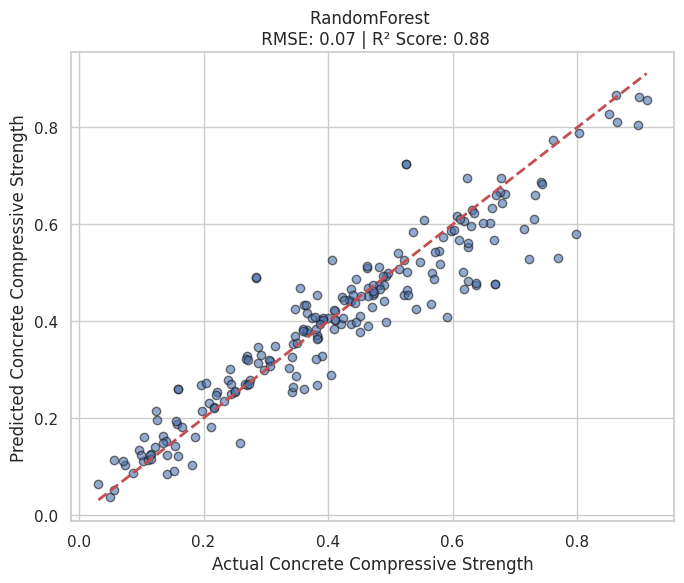

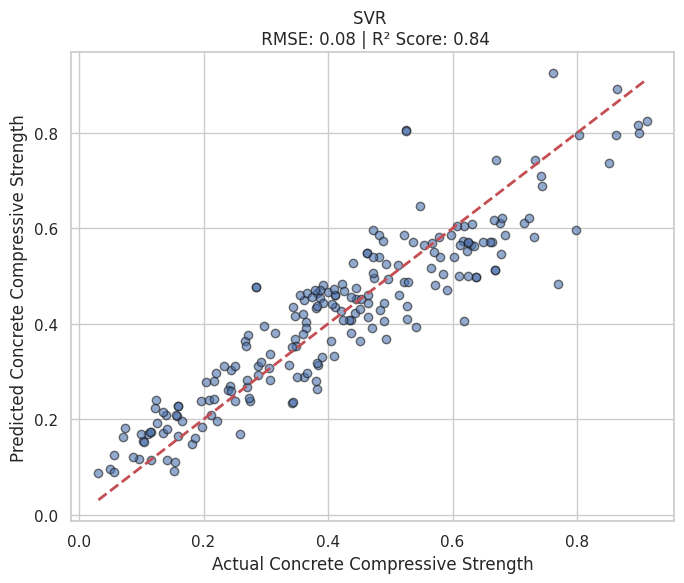

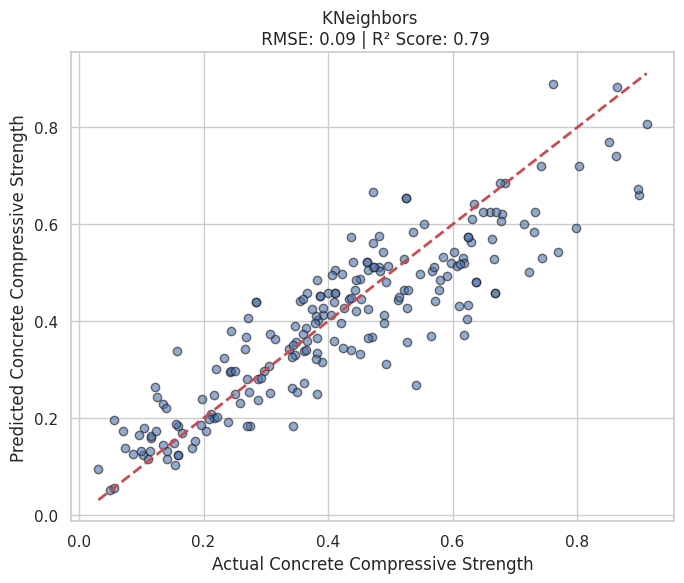

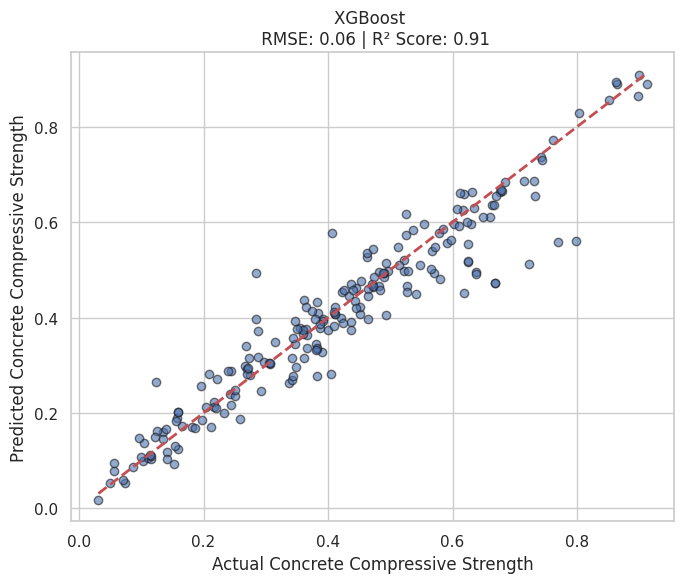


📊 Model Evaluation Results:
              Model  RMSE  R² Score
0  LinearRegression  0.10      0.74
1      DecisionTree  0.08      0.83
2      RandomForest  0.07      0.88
3               SVR  0.08      0.84
4        KNeighbors  0.09      0.79
5           XGBoost  0.06      0.91


In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress the DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

results = []  # To store results in tabular form

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append model performance to results list
    results.append({
        'Model': name,
        'RMSE': round(rmse, 2),
        'R² Score': round(r2, 2)
    })

    # Save model
    with open(f'{save_path}{name}_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    plt.figure(figsize=(7, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"{name} \n RMSE: {rmse:.2f} | R² Score: {r2:.2f}")
    #plt.title(f"{name} \nR² Score: {r2:.2f} | RMSE: {rmse:.2f}")
    plt.xlabel("Actual Concrete Compressive Strength")
    plt.ylabel("Predicted Concrete Compressive Strength")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a DataFrame from the results and display it
results_df = pd.DataFrame(results)
print("\n📊 Model Evaluation Results:")
print(results_df)

Metric Evaluation

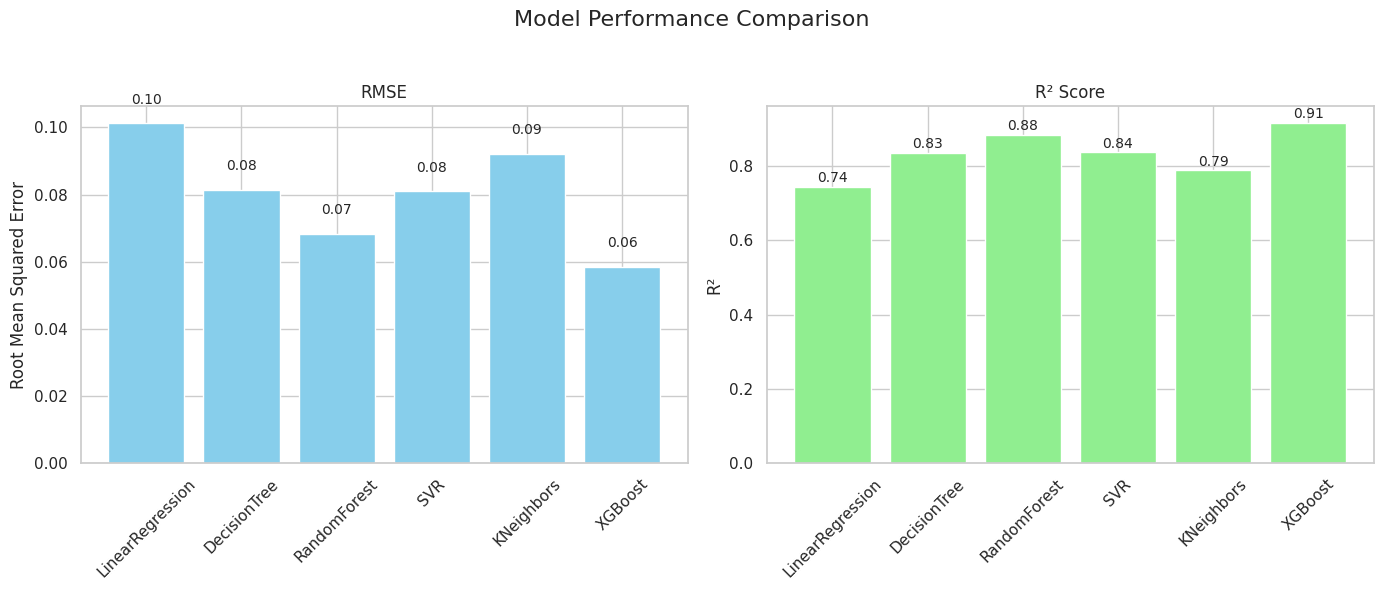

In [ ]:
results = {
    'Model': [],
    'RMSE': [],
    'R2 Score': []
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results['Model'].append(name)
    results['RMSE'].append(rmse)
    results['R2 Score'].append(r2)

results_df = pd.DataFrame(results)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot RMSE with value labels
ax[0].bar(results_df['Model'], results_df['RMSE'], color='skyblue')
ax[0].set_title('RMSE')
ax[0].set_ylabel('Root Mean Squared Error')
ax[0].tick_params(axis='x', rotation=45)

for i, v in enumerate(results_df['RMSE']):
    ax[0].text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# Plot R² with value labels
ax[1].bar(results_df['Model'], results_df['R2 Score'], color='lightgreen')
ax[1].set_title('R² Score')
ax[1].set_ylabel('R²')
ax[1].tick_params(axis='x', rotation=45)

for i, v in enumerate(results_df['R2 Score']):
    ax[1].text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Based on the evaluation metrics, XGBoost achieved the lowest RMSE (0.06) and the highest R² score (0.91) among all tested models. This indicates that XGBoost has the best predictive performance and generalization ability for estimating concrete compressive strength using the min-max normalized dataset.

Although all models demonstrated moderate accuracy, XGBoost outperformed others in capturing the relationship between input features and concrete strength. Therefore, XGBoost is recommended as the most suitable model for this regression task, especially when prediction accuracy is critical.

# Streamlit app code

In [ ]:
import warnings

# Suppress specific Streamlit warning
warnings.filterwarnings("ignore", message=".*missing ScriptRunContext.*")

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pickle

# --- Load the model and scalers ---
with open('models/XGBoost_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/minmax_scaler_X.pkl', 'rb') as f:
    minmax_scaler_X = pickle.load(f)

with open('models/minmax_scaler_y.pkl', 'rb') as f:
    minmax_scaler_y = pickle.load(f)

# --- UI Setup ---
st.set_page_config(page_title="Concrete Strength Predictor", layout="wide")

st.markdown("""
    <style>
    body {
        background-color: #e6f2ff;
    }
    </style>
""", unsafe_allow_html=True)

# --- Top Layout: Image + Title ---
top_col1, top_col2 = st.columns([1, 5])  # Adjust column width ratio as needed

with top_col1:
    st.image("images/concrete_logo.jpg", use_column_width=True)  # Replace with your actual image path

with top_col2:
    st.title("🏗️ Concrete Compressive Strength Predictor")


# --- Split the page into two columns ---
col1, col2 = st.columns(2)

with col1:
    st.header("Input Features")
    with st.form("input_form"):
        cement = st.number_input('Cement (kg/m³)', min_value=0.0)
        slag = st.number_input('Blast Furnace Slag (kg/m³)', min_value=0.0)
        fly_ash = st.number_input('Fly Ash (kg/m³)', min_value=0.0)
        water = st.number_input('Water (kg/m³)', min_value=0.0)
        superplasticizer = st.number_input('Superplasticizer (kg/m³)', min_value=0.0)
        coarse_agg = st.number_input('Coarse Aggregate (kg/m³)', min_value=0.0)
        fine_agg = st.number_input('Fine Aggregate (kg/m³)', min_value=0.0)
        age = st.number_input('Age (days)', min_value=1.0)

        submitted = st.form_submit_button("Predict Compressive Strength")

with col2:
    st.header("Prediction Result")
    if 'submitted' in locals() and submitted:
        input_data = np.array([[cement, slag, fly_ash, water, superplasticizer, coarse_agg, fine_agg, age]])

        # Step 1: Scale input features
        scaled_input = minmax_scaler_X.transform(input_data)

        # Step 2: Get scaled prediction
        scaled_prediction = model.predict(scaled_input)

        # Step 3: Inverse transform to get actual MPa prediction
        actual_prediction = minmax_scaler_y.inverse_transform([[scaled_prediction[0]]])[0][0]

        st.subheader(f'🔎 Predicted Compressive Strength: {actual_prediction:.2f} MPa')

        # Recommendation logic
        if actual_prediction > 50:
            st.success("✅ Recommended for tall buildings.")
            st.image("images/tall_building.jpg", caption="Tall Building", width=600)
        elif 30 < actual_prediction <= 50:
            st.info("✅ Recommended for medium-rise buildings.")
            st.image("images/medium_building.jpg", caption="Medium Raise Building", width=600)
        elif 20 < actual_prediction <= 30:
            st.warning("⚠️ Recommended for low-rise buildings.")
            st.image("images/low_building.jpg", caption="Low Raise Building", width=600)
        else:
            st.error("🚧 Suitable for roads, drains, or paver blocks.")
            st.image("images/roads.jpg", caption="Road Drain / Paver Block", width=600)


Overwriting app.py


In [ ]:
!curl https://loca.lt/mytunnelpassword

34.28.2.96

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.28.2.96:8501

⠼⠴your url is: https://giant-shirts-battle.loca.lt
2025-04-22 17:07:37.235 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-04-22 17:10:54.288 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
